<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Построение-и-обучение-модели" data-toc-modified-id="Построение-и-обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение и обучение модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Восстановление золота из руды

Нужно подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Необходимо использовать данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Цель исследования
Построить и обучить модель предсказания коэффициента восстановления золота из золотосодержащей руды.
Нужно спрогнозировать:
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

# Описание данных
**Технологический процесс**
- `Rougher feed` — исходное сырье
- `Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- `Xanthate`— ксантогенат (промотер, или активатор флотации);
- `Sulphate` — сульфат (на данном производстве сульфид натрия);
- `Depressant` — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота

**Параметры этапов**
- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики

Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В нашем распоряжении сырые данные: их просто выгрузили из хранилища. 

# Этапы исследования
1.  Подготовка данных
2.  Анализ данных
3.  Построение и обучение модели


## Подготовка данных

In [ ]:
# импортируем нужные библиотеки

import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# сохраним данные в отдельные переменные

train = pd.read_csv('***')
test = pd.read_csv('***')
full = pd.read_csv('***')

Посмотрим на первые 5 строк каждой таблицы.

In [ ]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [ ]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
# посмотрим общую информацию о данных

train.info()
test.info()
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
# выведем число пропусков по колонкам в каждой таблице

print(train.isna().sum())
print(test.isna().sum())
full.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64
date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

Пропуски есть. Позже их обработаем.

In [ ]:
# посчитаем суммарное число пропусков в каждой таблице

for data in [train, test, full]:
    print(data.isna().sum().sum())

4100
90
4481


Проверим, что эффективность обогащения рассчитана правильно. 
Эффективность обогащения рассчитывается по формуле:
![image.png](attachment:image.png)
где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Напишем функцию для расчета эффективности. Сделаем проверку для золота. 

In [ ]:
def recovery(data, c, f, t):
    return ((data[c]*(data[f]-data[t]))/\
           (data[f]*(data[c]-data[t])))*100

In [ ]:
check = recovery(train, 'rougher.output.concentrate_au', \
         'rougher.input.feed_au', 'rougher.output.tail_au')

In [ ]:
mean_absolute_error(train['rougher.output.recovery'], check)

9.73512347450521e-15

Ошибка маленькая. Можно считать, что расчеты в таблице правильные.

Проанализируем признаки, недоступные в тестовой выборке. Определим, что это за параметры и к какому типу они относятся.

In [ ]:
list(train.drop(test.columns, axis=1).columns)

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке отсутсвуют колонки с параметром продукта `output`, которые становятся известны после начала технологического процесса.

In [ ]:
# общее число пропусков в обучающей выборке
# без колонок тестовой выборки

train.drop(test.columns, axis=1).isna().sum().sum()

2395

Эти пропуски нас волновать не будут, т.к. колонки, которых нет в тестовой выборке, мы не будем использовать в обучении модели.

In [ ]:
# общее число пропусков в обучающей выборке
# в колонках соответствующих тестовой выборке

train[test.columns].isna().sum().sum()

1705

С этими пропусками уже нужно будет разобраться, т.к. эти колонки будут участвовать в обучении.

In [ ]:
# общее число пропусков в полной выборке
# в колонках соответствующих тестовой выборке
#full.drop(test.columns, axis=1).isna().sum().sum()

In [ ]:
# переведем колонку с датой в соответсвующий формат

for data in [train, test, full]:
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# проверим наличие явных дубликатов

print(train.duplicated().sum())
print(test.duplicated().sum())
print(full.duplicated().sum())

0
0
0


In [ ]:
# создадим список колонок, которые оставим в обучающей выборке

columns = list(test.columns)
columns.append('rougher.output.recovery')
columns.append('final.output.recovery')

In [ ]:
train = train[columns]

In [ ]:
# посмотрим на пропуски в обновленной таблице train

train.isna().sum()

date                                            0
primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       144
rougher.input.feed_sol                         78
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate              29


Т.к. у нас рассматривается технологический процесс во времени, то логично, что мы можем заполнить пропуски путем распространения последнего наблюдения на следующее. Для этого остортируем данные по времени и затем заполним сами пропуски.

In [ ]:
train = train.sort_values('date')

In [ ]:
train = train.fillna(method="ffill")

In [ ]:
train.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

Посмотрим на распределения эффективностей обогащения чернового и финального концентратов.

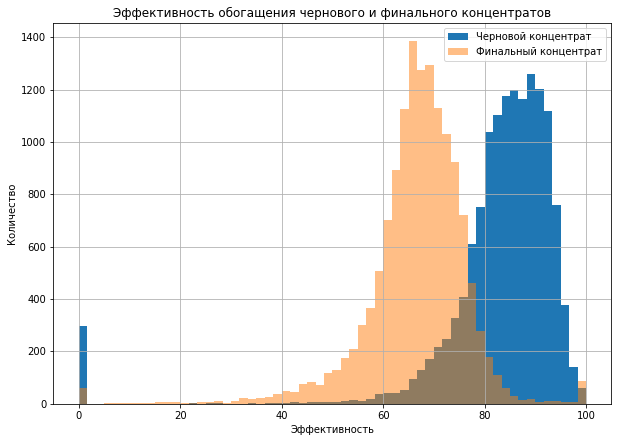

In [ ]:
train['rougher.output.recovery'].hist(bins=60, figsize=(10,7), legend=True);
train['final.output.recovery'].hist(bins=60, figsize=(10,7), legend=True, alpha=0.5);
plt.legend(['Черновой концентрат','Финальный концентрат'])
plt.title('Эффективность обогащения чернового и финального концентратов')
plt.xlabel('Эффективность')
plt.ylabel('Количество');

Видно, что есть нули. Они могут помешать в обучении. Удалим их.

In [ ]:
train = train.loc[(train['final.output.recovery'] != 0)&(train['rougher.output.recovery'] != 0)]

**Выводы**

В данных эффективность обогащения рассчитана правильно. Есть пропуски. В таблице `test` нет колонок с данными, которые известны после начала технологического процесса - от них избавились, т.к. они в обучении участвовать не будут. Имеющиеся пропуски заполнили путем распространением данных предыдущего наблюдения на следующее. Удалили наблюдения с нулевыми значениями эффективности обогащения, чтобы не искажать работу модели.


## Анализ данных

Проследим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Найдем интересующие колонки.

In [ ]:
full.columns[full.columns.str.endswith('au')],\
full.columns[full.columns.str.endswith('ag')],\
full.columns[full.columns.str.endswith('pb')]

(Index(['final.output.concentrate_au', 'final.output.tail_au',
        'primary_cleaner.output.concentrate_au',
        'primary_cleaner.output.tail_au', 'rougher.input.feed_au',
        'rougher.output.concentrate_au', 'rougher.output.tail_au',
        'secondary_cleaner.output.tail_au'],
       dtype='object'),
 Index(['final.output.concentrate_ag', 'final.output.tail_ag',
        'primary_cleaner.output.concentrate_ag',
        'primary_cleaner.output.tail_ag', 'rougher.input.feed_ag',
        'rougher.output.concentrate_ag', 'rougher.output.tail_ag',
        'secondary_cleaner.output.tail_ag'],
       dtype='object'),
 Index(['final.output.concentrate_pb', 'final.output.tail_pb',
        'primary_cleaner.output.concentrate_pb',
        'primary_cleaner.output.tail_pb', 'rougher.input.feed_pb',
        'rougher.output.concentrate_pb', 'rougher.output.tail_pb',
        'secondary_cleaner.output.tail_pb'],
       dtype='object'))

In [ ]:
# данные по каждому металлу сохраним в отдельную переменную

au = full[['rougher.input.feed_au', 'rougher.output.concentrate_au',\
'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].dropna()
ag = full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag',\
'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].dropna()
pb = full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',\
'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].dropna()

In [ ]:
# выведем медианную концентрацию
# по каждому металлу на каждом этапе

print('До флотации:')
print('ag:{: 0.2f}, pb:{: 0.2f}, au:{: 0.2f}'.\
format(ag['rougher.input.feed_ag'].median(),
       pb['rougher.input.feed_pb'].median(),
       au['rougher.input.feed_au'].median()))
print()
print('После флотации:')
print('ag:{: 0.2f}, pb:{: 0.2f}, au:{: 0.2f}'.\
format(ag['rougher.output.concentrate_ag'].median(),
       pb['rougher.output.concentrate_pb'].median(),
       au['rougher.output.concentrate_au'].median()))
print()
print('После первичной очистки:')
print('ag:{: 0.2f}, pb:{: 0.2f}, au:{: 0.2f}'.\
format(ag['primary_cleaner.output.concentrate_ag'].median(),
       pb['primary_cleaner.output.concentrate_pb'].median(),
       au['primary_cleaner.output.concentrate_au'].median()))
print()
print('Финальная концентрация:')
print('ag:{: 0.2f}, pb:{: 0.2f}, au:{: 0.2f}'.\
format(ag['final.output.concentrate_ag'].median(),
       pb['final.output.concentrate_pb'].median(),
       au['final.output.concentrate_au'].median()))

До флотации:
ag: 8.59, pb: 3.54, au: 8.13

После флотации:
ag: 12.10, pb: 7.75, au: 20.28

После первичной очистки:
ag: 8.51, pb: 10.16, au: 32.84

Финальная концентрация:
ag: 5.07, pb: 10.12, au: 45.01


Медианная концентрация золота растет. У свинца в принципе тоже. А вот медианная концентрация серебра по итогу снижается. Посмотрим на распределения концентраций по каждому металлу на каждом этапе.

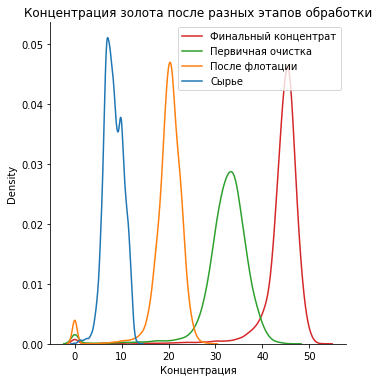

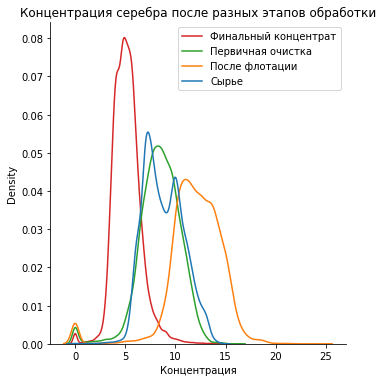

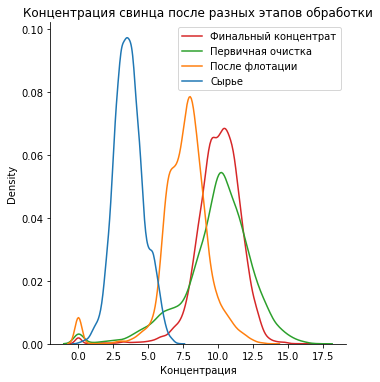

In [ ]:
for m, m_name in zip([au, ag, pb], ['золота', 'серебра', 'свинца']):
    sns.displot(m, legend=False, kind='kde')
    plt.title(f'Концентрация {m_name} после разных этапов обработки')
    plt.legend(['Финальный концентрат','Первичная очистка','После флотации', 'Сырье'])
    plt.xlabel('Концентрация');

Распределения подтверждают выводы по медианам. Концентрация золота заметно растет.

**Сравнение распределений размеров гранул сырья на обучающей и тестовой выборках**

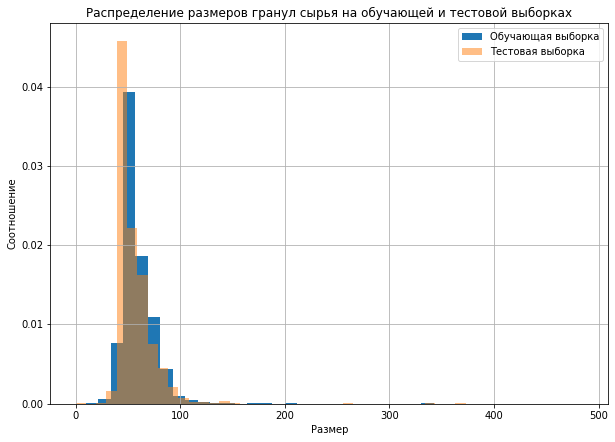

In [ ]:
train['rougher.input.feed_size'].hist(figsize=(10,7), bins=40, density=True);
test['rougher.input.feed_size'].hist(figsize=(10,7), bins=40, alpha=0.5, density=True);
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках')
plt.legend(['Обучающая выборка','Тестовая выборка']);
plt.xlabel('Размер');
plt.ylabel('Соотношение');

Как видно, распределения схожи. Ожидаем правильную оценку модели.

 **Суммарная концентрация всех веществ на разных стадиях**

In [ ]:
feed = full['rougher.input.feed_au']+full['rougher.input.feed_ag']\
       +full['rougher.input.feed_pb']+full['rougher.input.feed_sol']
rougher = full['rougher.output.concentrate_au']+full['rougher.output.concentrate_ag']\
          +full['rougher.output.concentrate_pb']+full['rougher.output.concentrate_sol']
final = full['final.output.concentrate_au']+full['final.output.concentrate_ag']\
          +full['final.output.concentrate_pb']+full['final.output.concentrate_sol']

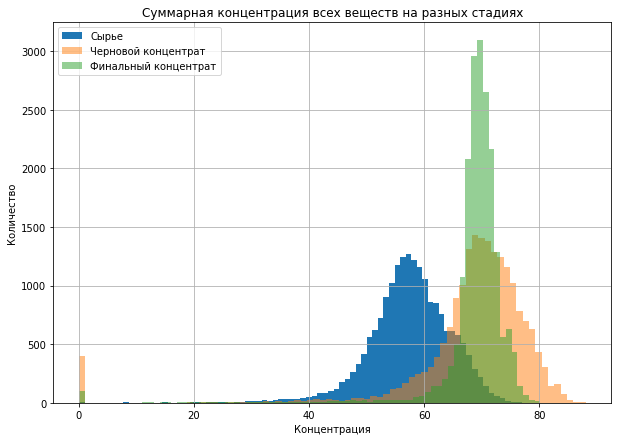

In [ ]:
feed.hist(figsize=(10,7), bins=80);
rougher.hist(figsize=(10,7), bins=80, alpha=0.5);
final.hist(figsize=(10,7), bins=80, alpha=0.5);
plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.legend(['Сырье','Черновой концентрат', 'Финальный концентрат']);
plt.xlabel('Концентрация');
plt.ylabel('Количество');

Видим, что к финальной стадии суммарная концентрация всех веществ закономерно растет.

**Выводы**

Концентрация золота и свинца растет по мере очистки. Концентрация серебра падает. Но суммарная концентрация веществ все же растет.
Распределения размеров гранул сырья на обучающей и тестовой выборках схожи.


## Построение и обучение модели

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Симметричная, т.к. она одинаково учитывает масштаб и целевого признака, и предсказания.
![image-2.png](attachment:image-2.png)

Итоговая метрика складывается из двух величин:
![image.png](attachment:image.png)

Напишем функцию для вычисления итоговой sMAPE.

In [ ]:
def smape(true, pred):
    n = 0
    for i in range(len(true)):
        n += (abs(true[i]-pred[i]))/((abs(true[i])+abs(pred[i]))/2)
    return (n/len(true))*100

In [ ]:
def total_smape(rougher_smape, final_smape):
    return 0.25*rougher_smape + 0.75*final_smape

In [ ]:
# введем соответствующий оценщик

smape_score = make_scorer(smape, greater_is_better=False)

In [ ]:
# избавимся от пропусков в test

test = test.sort_values('date')
test = test.fillna(method="ffill")

In [ ]:
test.isna().sum().sum()

0

Чтобы мы могли проверить качетво модели на тестовой выборке, нам нужно иметь значения целевых переменных. Возьмем их из таблицы `full`. Для этого сделаем колонку `date` в таблицах индексами и перенесем значения целевых переменных по индексам в `test`.

Уберем из таблицы `full` явные аномальные строки, чтобы взять из нее только релевантные для обучения наблюдения.

In [ ]:
full = full.query('@feed > 1 & @rougher > 20 & @final > 20')

In [ ]:
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)
full.set_index('date', inplace=True)

In [ ]:
train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [ ]:
train = pd.merge(train, full[['rougher.output.recovery', 'final.output.recovery']],
         left_index=True, right_index=True)

In [ ]:
test = pd.merge(test, full[['rougher.output.recovery', 'final.output.recovery']],
         left_index=True, right_index=True)

In [ ]:
# разделим данные на параметры и целевые переменные

features_train = train.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
target_rougher_train = train['rougher.output.recovery']
target_final_train = train['final.output.recovery']
features_test = test.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
target_rougher_test = test['rougher.output.recovery']
target_final_test = test['final.output.recovery']

In [ ]:
# масштабируем данные для лучшего качетсва моделей

columns = list(features_train.columns)
scaler = StandardScaler()
scaler.fit(features_train)
features_train[columns] = scaler.transform(features_train[columns])
features_test[columns] = scaler.transform(features_test[columns])

Последовательно построим и обучим модели случайного леса, дерева решений и лассо. Проверим их качество кросс-валидацией. Подберем оптимальные гиперпараметры. Оценим значения метрик sMAPE и итогового sMAPE.

In [ ]:
# строим и обучаем случайный лес, смотрим метрики

forestreg = RandomForestRegressor(random_state=12345)
forestreg_params = {'n_estimators': range(10, 61, 10), 'max_depth': range(1, 10)}
forestreg_rougher = RandomizedSearchCV(forestreg, forestreg_params, cv=5, scoring=smape_score, n_jobs=-1)
forestreg_final = RandomizedSearchCV(forestreg, forestreg_params, cv=5, scoring=smape_score, n_jobs=-1)
forestreg_rougher.fit(features_train, target_rougher_train)
forestreg_final.fit(features_train, target_final_train)
print('sMAPE эффективности обогащения чернового концентрата:', forestreg_rougher.best_score_)
print('sMAPE эффективности обогащения финального концентрата:', forestreg_final.best_score_)
print('Итоговое sMAPE:', total_smape(forestreg_rougher.best_score_, forestreg_final.best_score_))

sMAPE эффективности обогащения чернового концентрата: -6.706500249128524
sMAPE эффективности обогащения финального концентрата: -8.409885898351844
Итоговое sMAPE: -7.984039486046013


In [ ]:
# строим и обучаем дерево решений, смотрим метрики

treereg = DecisionTreeRegressor(random_state=12345)
treereg_params = {'max_depth': range(1, 10)}
treereg_rougher = RandomizedSearchCV(treereg, treereg_params, cv=5, scoring=smape_score, n_jobs=-1)
treereg_final = RandomizedSearchCV(treereg, treereg_params, cv=5, scoring=smape_score, n_jobs=-1)
treereg_rougher.fit(features_train, target_rougher_train)
treereg_final.fit(features_train, target_final_train)
print('sMAPE эффективности обогащения чернового концентрата:', treereg_rougher.best_score_)
print('sMAPE эффективности обогащения финального концентрата:', treereg_final.best_score_)
print('Итоговое sMAPE:', total_smape(treereg_rougher.best_score_, treereg_final.best_score_))

sMAPE эффективности обогащения чернового концентрата: -7.025541589567306
sMAPE эффективности обогащения финального концентрата: -9.033522839875957
Итоговое sMAPE: -8.531527527298794


In [ ]:
# строим и обучаем лассо, смотрим метрики

lasso = Lasso(random_state=12345)
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
lasso_rougher = RandomizedSearchCV(lasso, lasso_params, cv=5, scoring=smape_score, n_jobs=-1)
lasso_final = RandomizedSearchCV(lasso, lasso_params, cv=5, scoring=smape_score, n_jobs=-1)
lasso_rougher.fit(features_train, target_rougher_train)
lasso_final.fit(features_train, target_final_train)
print('sMAPE эффективности обогащения чернового концентрата:', lasso_rougher.best_score_)
print('sMAPE эффективности обогащения финального концентрата:', lasso_final.best_score_)
print('Итоговое sMAPE:', total_smape(lasso_rougher.best_score_, lasso_final.best_score_))

sMAPE эффективности обогащения чернового концентрата: -6.564055237226375
sMAPE эффективности обогащения финального концентрата: -9.604969545749615
Итоговое sMAPE: -8.844740968618805


Лучший итоговый результат показала модель лассо.

Протестируем лучшую модель на тестовой выборке.

In [ ]:
rougher_pred = lasso_rougher.predict(features_test)
final_pred = lasso_final.predict(features_test)
print('Итоговое sMAPE на тестовой выборке:', \
      total_smape(smape(target_rougher_test, rougher_pred),\
                  smape(target_final_test, final_pred)))
print(lasso_rougher.best_params_)
print(lasso_final.best_params_)

Итоговое sMAPE на тестовой выборке: 6.910374761092424
{'alpha': 0.03}
{'alpha': 0.03}


Сравним качество работы нашей модели с константной моделью, которая предсказывает медиану.

In [ ]:
dummy_rougher = DummyRegressor(strategy='median')
dummy_final = DummyRegressor(strategy='median')
dummy_rougher.fit(features_train, target_rougher_train)
dummy_final.fit(features_train, target_final_train)
dummy_rougher_pred = dummy_rougher.predict(features_train)
dummy_final_pred = dummy_final.predict(features_train)
print('Итоговое sMAPE на константной модели:', \
      total_smape(smape(target_rougher_test, dummy_rougher_pred),\
                  smape(target_final_test, dummy_final_pred)))

Итоговое sMAPE на константной модели: 7.201685692679165


У константной модели результат хуже, чем у нашей лучшей модели. Значит, все посчитано верно.

**Выводы**

Лучшую метрику sMAPE на обучающей выборке показала модель лассо с параметром `alpha` = 0.03. Результат модели на тестовой выборке 6.91.


## Общий вывод

Для предсказания эффективности обогащения чернового и финального концентрата рекомендуется использовать модель лассо с параметром `alpha` = 0.03.